# Proyecto 03 - Series de Tiempo - Juan Miguel Salazar Muñoz (DS Grupo 58)

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

In [114]:
data_2019 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2017.csv', sep =',')

In [115]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [116]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [117]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [118]:
print("Datos úinicos 2019",data_2019['estacion'].unique())
print("")
print("Datos úinicos 2018",data_2018['estacion'].unique())
print("")
print("Datos úinicos 2017",data_2017['estacion'].unique())

Datos úinicos 2019 ['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

Datos úinicos 2018 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Datos úinicos 2017 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [119]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [120]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [121]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [169]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])
dataset.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [170]:
formadepago = dataset


In [124]:
formadepago.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
19,2019,2019-01-01,0,1,Martes,Illia,Centro,Liviano,NO COBRADO,146
20,2019,2019-01-01,0,1,Martes,Illia,Centro,Liviano,TELEPASE,59
21,2019,2019-01-01,0,1,Martes,Illia,Centro,Pesado,TELEPASE,1
22,2019,2019-01-01,0,1,Martes,Illia,Provincia,Liviano,NO COBRADO,147
23,2019,2019-01-01,0,1,Martes,Illia,Provincia,Liviano,TELEPASE,106


In [125]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [126]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [127]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [128]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


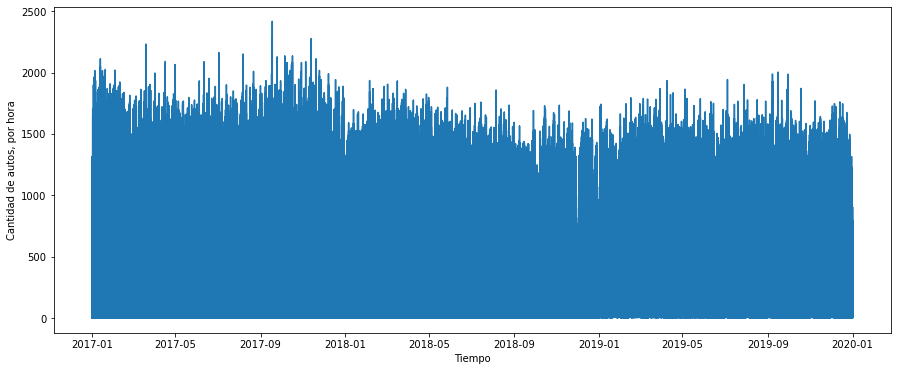

In [129]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [130]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


# 2.1 Análisis de Datos

Comenzaremos a analisar los datos con los que se trabajaran en este proyecto. 


Como primer paso, se visualizaran los datos en diferentes granularidades para comprender si deben recibir un tratamiento de preprocesamiento previo a un análisis de datos más profundos. 


Las granularidades que se analizaran serán de manera diaria y mensual, ya que serán con esas granularidades que se desarrollará el modelo predictivo y lograr predecir el último trimestre del 2019. 

### A) Datos a Diario

In [131]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha2').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha2,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


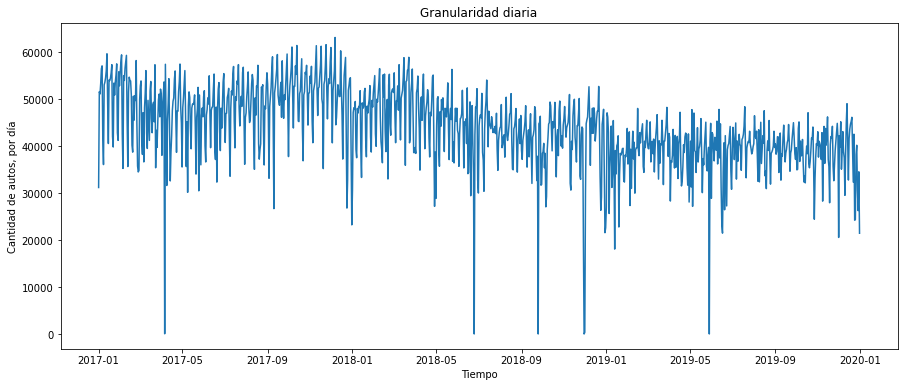

In [132]:
#Graficamos nuestros datos de manera diaria
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.title('Granularidad diaria')
plt.show()

In [133]:
print("Los valores faltantes por cada columna son: ")
print(diario.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    0
dtype: int64


#### Conclusiones

Una vez realizados las visualizaciones de los datos se puede concluir que la serie cuenta con valores outliers que deberán ser eliminados para el correcto funcionamiento de los modelos predictivos. 

### Datos a Semanas

In [134]:
#Resampleamos nuestros datos para agrupar por mes.
semanal = dataset.resample('W', on = 'fecha2').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha2,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


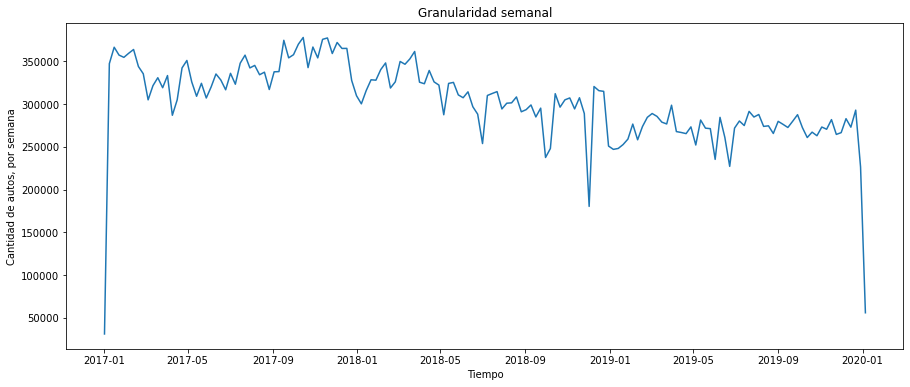

In [135]:
#Graficamos nuestros de manera semanal
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Granularidad semanal')
plt.show()

### C) Datos a Meses

In [136]:
#Resampleamos nuestros datos para agrupar por mes.
mensual = dataset.resample('M', on = 'fecha2').sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha2,
2017-01-31,1565260
2017-02-28,1363113
2017-03-31,1451214
2017-04-30,1373985
2017-05-31,1407136


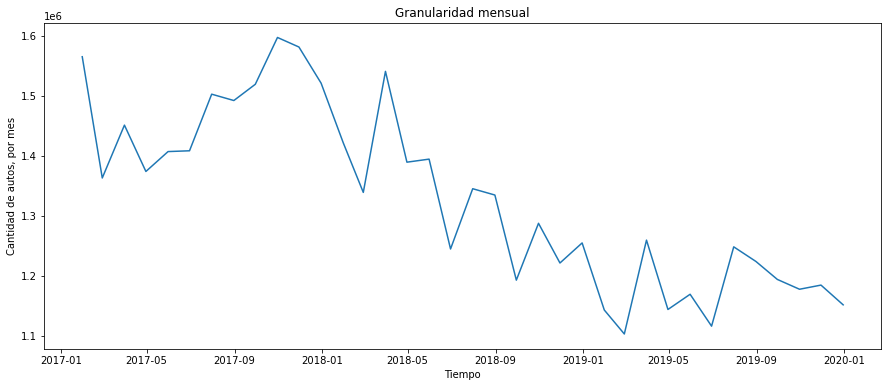

In [137]:
#Graficamos nuestros de manera mensual
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.title('Granularidad mensual')
plt.show()

In [138]:
print("Los valores faltantes por cada columna son: ")
print(mensual.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    0
dtype: int64


#### Conclusiones

Una vez realizados las visualizaciones de los datos se puede concluir que la serie no cuenta con valores outliers. Pero se debe tomar en cuenta que se arrastrán los outliers encontrados en la granularidad diaria. Por lo que es preciso modificar los outlieres de manera diaria para una conclusión precisa sobre los datos mensuales. 

# 3. Preprocesamiento de datos

## A) Eliminación de valores outliers en granularidad diaria

A continuación, se procederá a realizar la eliminación de los outliers en la granularidad diaria

In [139]:
diario.head()

,cantidad_pasos
fecha2,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


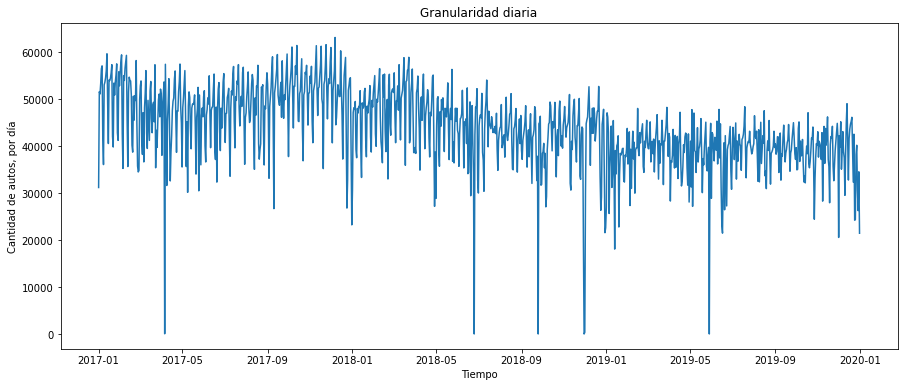

In [140]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.title('Granularidad diaria')
plt.show()

Para eliminar los outliers, se considerará el valor mínimo en la serie de datos a partir de 20,000.

In [141]:
diario[diario.cantidad_pasos<=20000] = np.nan

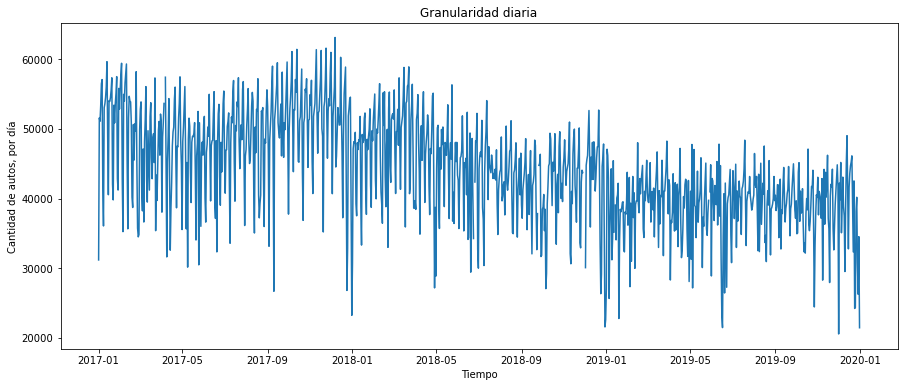

In [142]:
#Graficamos nuestros datos de manera diaria
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.title('Granularidad diaria')
plt.show()

In [143]:
print("Los valores faltantes por cada columna son: ")
print(diario.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    8
dtype: int64


Se puede apreciar en el gráfico que los outliers iniciales fueron removidos correctamente. Sin embargo, al realizarlo hemos eliminado 7 datos de los días (outlieres) que deberán ser rellenados para contar con una serie de tiempo completa. 

## B) Imputación de fechas faltantes

Se utilizará la técnica interpolate para imputar los datos faltantes por su sencillez de uso. 

In [144]:
diario = diario.interpolate() 

In [145]:
print("Los valores faltantes por cada columna son: ")
print(diario.isna().sum())

Los valores faltantes por cada columna son: 
cantidad_pasos    0
dtype: int64


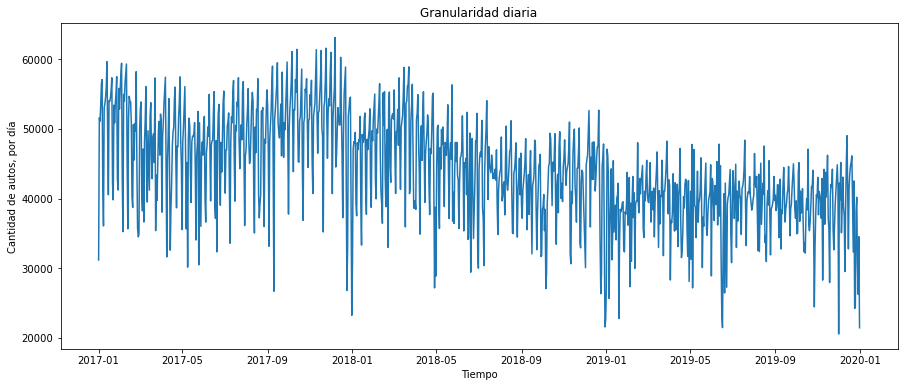

In [146]:
#Graficamos nuestros datos de manera diaria
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por día')
plt.title('Granularidad diaria')
plt.show()

## C) Granularidad semanal

In [147]:
diario2=diario.copy()
diario2.reset_index(inplace = True)
diario2.head()

,fecha2,cantidad_pasos
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0


In [148]:
semanal = diario2.resample('W', on = "fecha2").sum()
print(semanal.shape)

(158, 1)


In [149]:
semanal.tail()

,cantidad_pasos
fecha2,
2019-12-08,282891.0
2019-12-15,272960.0
2019-12-22,292881.0
2019-12-29,226390.0
2020-01-05,55970.0


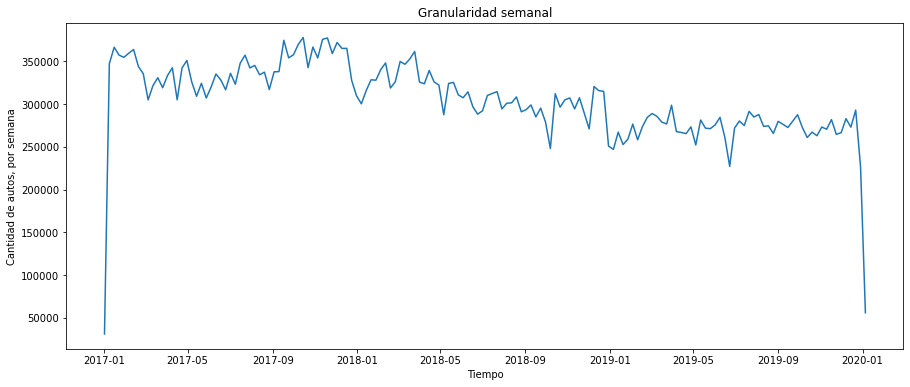

In [150]:
#Graficamos nuestros de manera semanal
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Granularidad semanal')
plt.show()

In [151]:
#Eliminando la primer fila y la última fila del dataset semanal
semanal = semanal.loc[(semanal.index > '2017-01-01')]
semanal = semanal.loc[(semanal.index < '2020-01-05')]
print(semanal.shape)
semanal.head()

(156, 1)


,cantidad_pasos
fecha2,
2017-01-08,347212.0
2017-01-15,366413.0
2017-01-22,357215.0
2017-01-29,354581.0
2017-02-05,359401.0


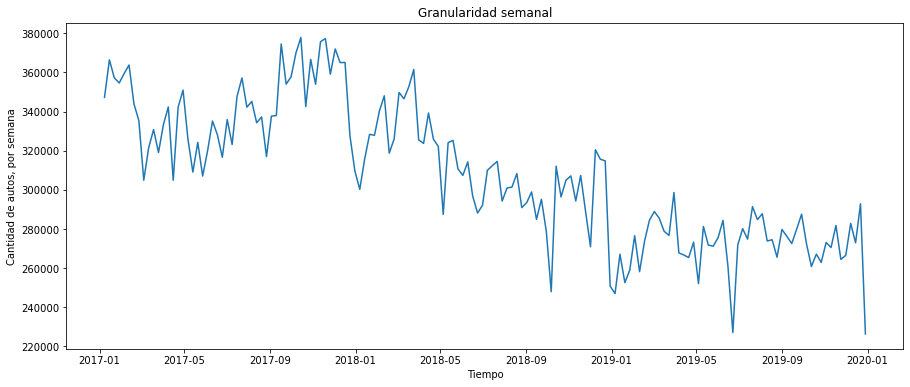

In [152]:
#Graficamos nuestros de manera semanal
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Granularidad semanal')
plt.show()

## D) Granularidad mensual

In [153]:
diario2=diario.copy()

In [154]:
diario2.reset_index(inplace = True)

In [155]:
diario2.head()

,fecha2,cantidad_pasos
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0


In [156]:
mensual = diario2.resample('M', on = "fecha2").sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha2,
2017-01-31,1565260.0
2017-02-28,1363113.0
2017-03-31,1451214.0
2017-04-30,1429482.0
2017-05-31,1407136.0


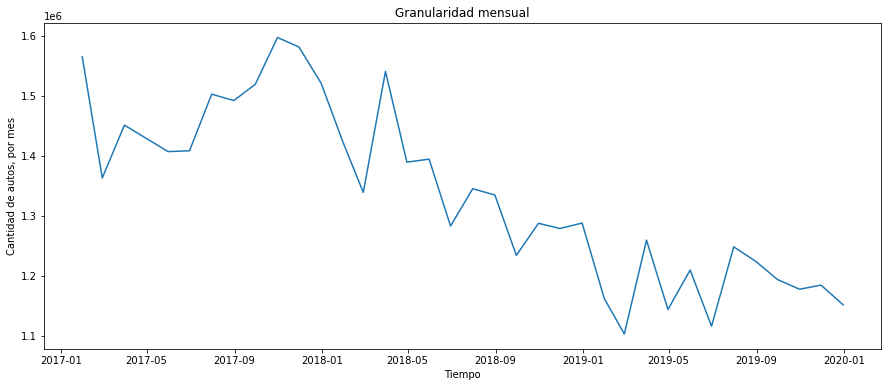

In [157]:
#Graficamos nuestros de manera mensual
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.title('Granularidad mensual')
plt.show()

# 2.2 Análisis de Datos

Text(0.5, 1.0, 'Tipos de automóviles en Illia')

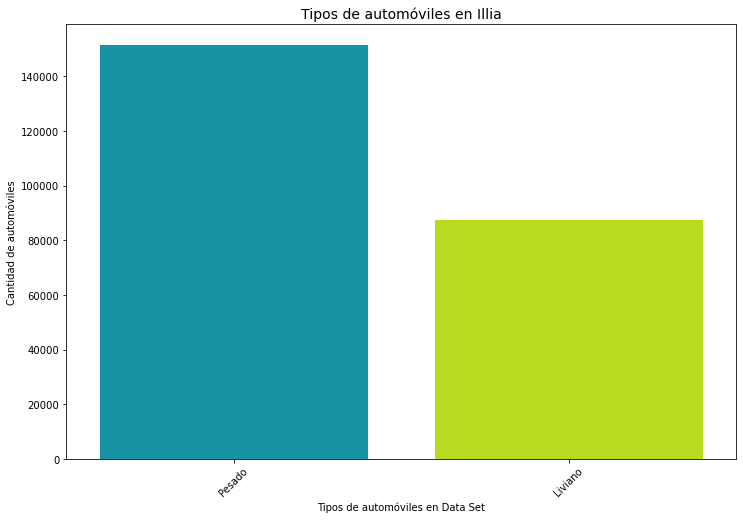

In [158]:
plt.figure(figsize = (12,8))
sns.countplot(data = dataset, x = "tipo_vehiculo", order = dataset['tipo_vehiculo'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Tipos de automóviles en Data Set')
plt.ylabel('Cantidad de automóviles')
plt.title('Tipos de automóviles en Illia', fontsize=14)

Se puede observar en la gráfica que en la estación Illia el mayor tráfico se da por transporte denominado como Pesado. 

Text(0.5, 1.0, 'Sentido de los automóviles')

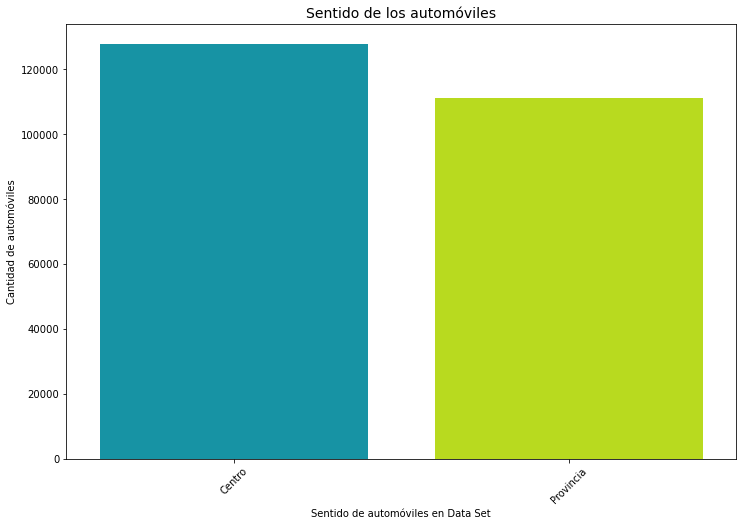

In [159]:
plt.figure(figsize = (12,8))
sns.countplot(data = dataset, x = "sentido", order = dataset['sentido'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Sentido de automóviles en Data Set')
plt.ylabel('Cantidad de automóviles')
plt.title('Sentido de los automóviles', fontsize=14)

Analizando la gráfica, se puede ver que la dirección que presenta más flujo vehicular en la estación Illia es aquella que va al centro. 

Text(0.5, 1.0, 'Días de la semana y su tráfico')

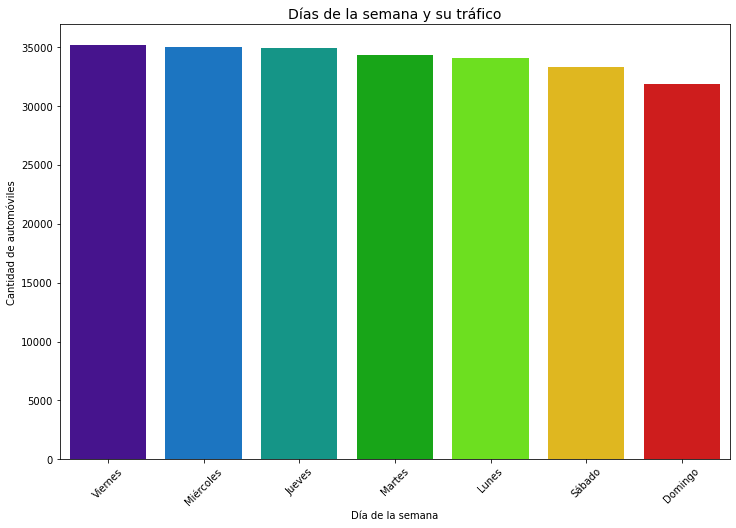

In [160]:
plt.figure(figsize = (12,8))
sns.countplot(data = dataset, x = "dia", order = dataset['dia'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de automóviles')
plt.title('Días de la semana y su tráfico', fontsize=14)

Se puede apreciar en la gráfica que el día que llega a presentar más afluencia vehicular es el viernes, seguido del miércoles. 


El día de la semana que presenta menos afluencia vehicular es el domingo. 

### ¿Cuál ha sido el método de pago más utilizado en cada año evaluado?

In [171]:
formadepago.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [172]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
formadepago['fecha2'] = pd.to_datetime(formadepago.fecha)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
formadepago.drop(columns=['fecha'], inplace = True)

formadepago.head()

,periodo,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
0,2019,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01
1,2019,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01
2,2019,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53,2019-01-01
3,2019,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18,2019-01-01
4,2019,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01


In [178]:
mask2 = formadepago.estacion=='Illia'
formadepago = dataset[mask2]

In [179]:
mask17= formadepago.periodo == 2017
mask18= formadepago.periodo == 2018
mask19= formadepago.periodo == 2019

In [180]:
pago17 = formadepago[mask17]
pago18 = formadepago[mask18]
pago19 = formadepago[mask19]

Text(0.5, 1.0, 'Forma de Pago más utilizado en Illia en 2019')

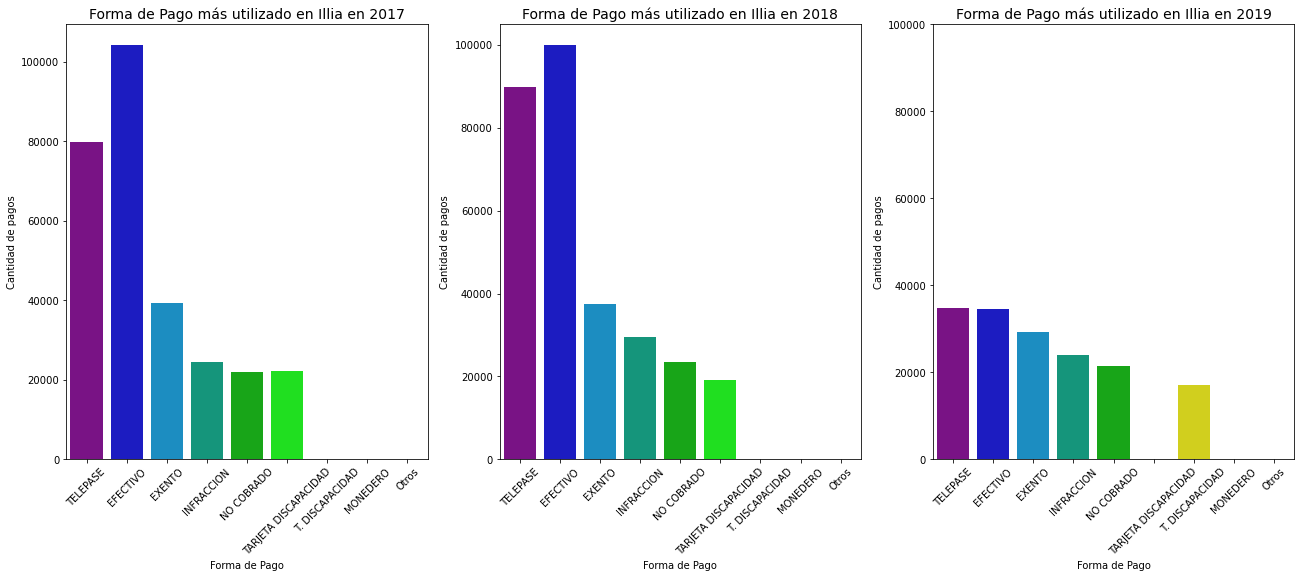

In [181]:
plt.figure(figsize=(22,8))
plt.subplot(1,3,1)
sns.countplot(data = pago17, x = "forma_pago", order = dataset['forma_pago'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Forma de Pago')
plt.ylabel('Cantidad de pagos')
plt.title('Forma de Pago más utilizado en Illia en 2017', fontsize=14)


plt.subplot(1,3,2)
sns.countplot(data = pago18, x = "forma_pago", order = dataset['forma_pago'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Forma de Pago')
plt.ylabel('Cantidad de pagos')
plt.title('Forma de Pago más utilizado en Illia en 2018', fontsize=14)



plt.subplot(1,3,3)
sns.countplot(data = pago19, x = "forma_pago", order = dataset['forma_pago'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.ylim([0, 100000])
plt.xlabel('Forma de Pago')
plt.ylabel('Cantidad de pagos')
plt.title('Forma de Pago más utilizado en Illia en 2019', fontsize=14)

Analizando el análisis, se puede apreciar como el método de pago "Telepase" ha ido igualando la cantidad de transacciones con el paso de estos 3 últimos años frente a efectivo. 


La forma de pago de "T. Discapacidad" comienza a reportar trasnacciones hasta el año 2019 en Illia. 


La forma de pago "Monedero" no presenta transacciones en los años que son analizados. 


Se puede apreicar el declive de las transacciones en la estación Illia para el año 2019.


#### Tendencia, estacionalidad y residuos semanal

In [265]:
semanal

,cantidad_pasos
fecha2,
2017-01-08,347212.0
2017-01-15,366413.0
2017-01-22,357215.0
2017-01-29,354581.0
2017-02-05,359401.0
...,...
2019-12-01,266555.0
2019-12-08,282891.0
2019-12-15,272960.0


In [182]:
result = seasonal_decompose(semanal.cantidad_pasos, model='additive')

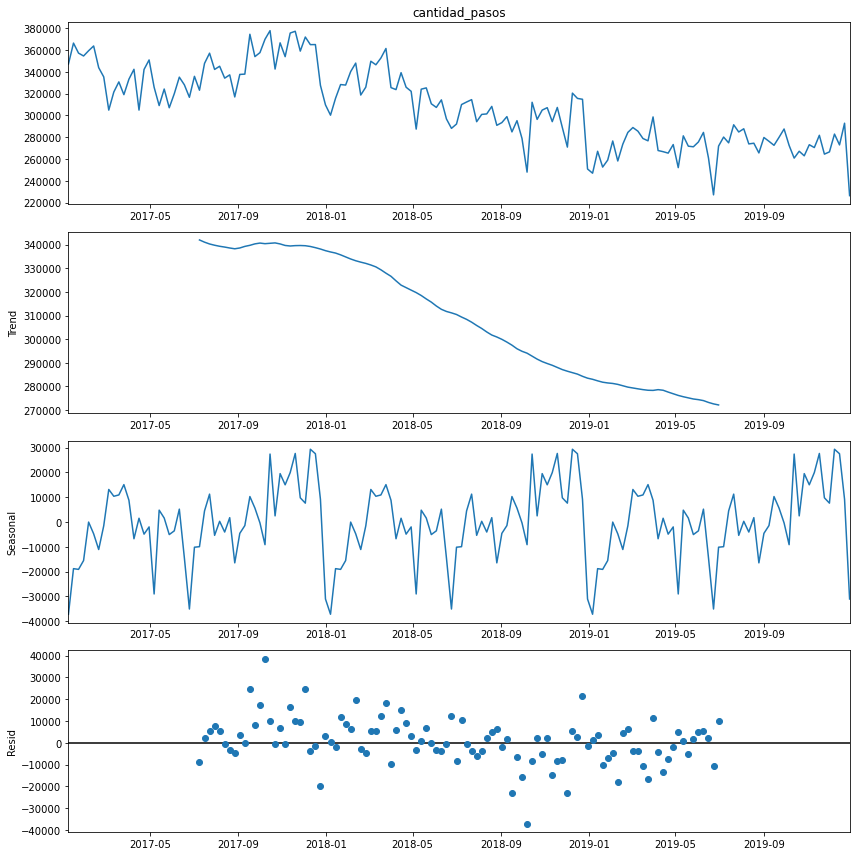

In [183]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

#### Tendencia, estacionalidad y residuos mensual

In [185]:
result = seasonal_decompose(mensual.cantidad_pasos, model='additive')

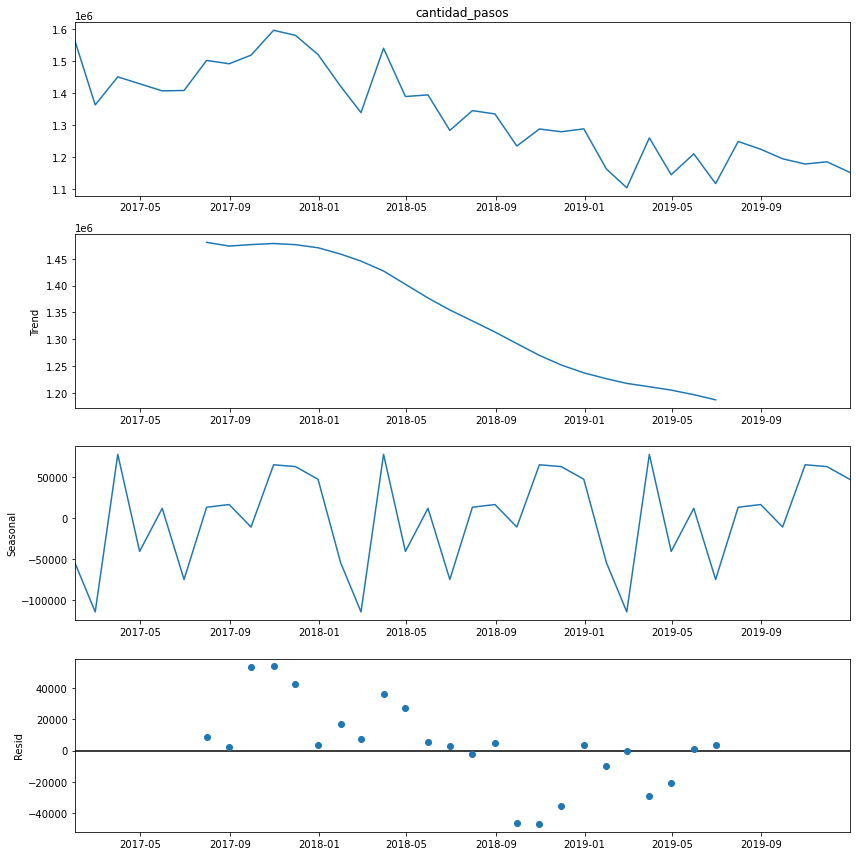

In [186]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

### Conclusiones


Se puede comprobar la tendencia a la baja del tráfico en la estación Illia con el gráfico de trend. 


Con el gráfico de estacionalidad, se puede determinar el decremento de tráfico en los meses febrero, marzo y abril. Un aumento entre abril y mayo, posiblemente atribuible a las vacaciones de semana santa, y un aumento en los meses finales del año, que pueden ser atribuibles a las vacaciones decembrinas. 


El gráfico de residuos no presenta comportamiento alguno, se presentan los puntos de manera aleatoria. Esto nos indica que los datos vienen presentados en una buena granularidad, apropiada para realizar sobre de ellos modelos predictivos. 


Analizando las dos granularidades, se opta por trabajar con la semanal, ya que contaremos con más datos para poder realizar las predicciones. 

#### Autocorrelaciones

In [187]:
nlags = 104 #El periodo a evaluar, las semanas en un dos años
autocorr = acf(semanal.cantidad_pasos, nlags = nlags,fft=False)

Text(0.5, 1.0, 'Autocorrelación en la granularidad mensual')

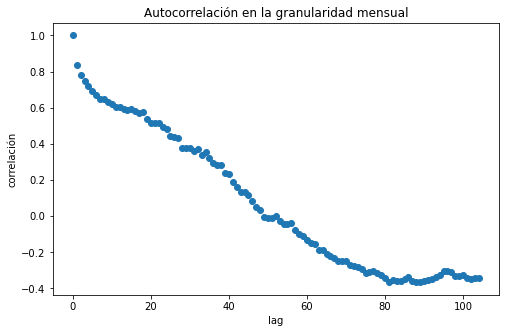

In [188]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.ylabel ('correlación')
plt.title('Autocorrelación en la granularidad mensual')

Podemos apreciar que la correlación de la serie de datos consigo misma disminuye con el paso del tiempo. Esto se relaciona con la disminución de tráfico que hubo en el año 2019 en la estación Illia. 

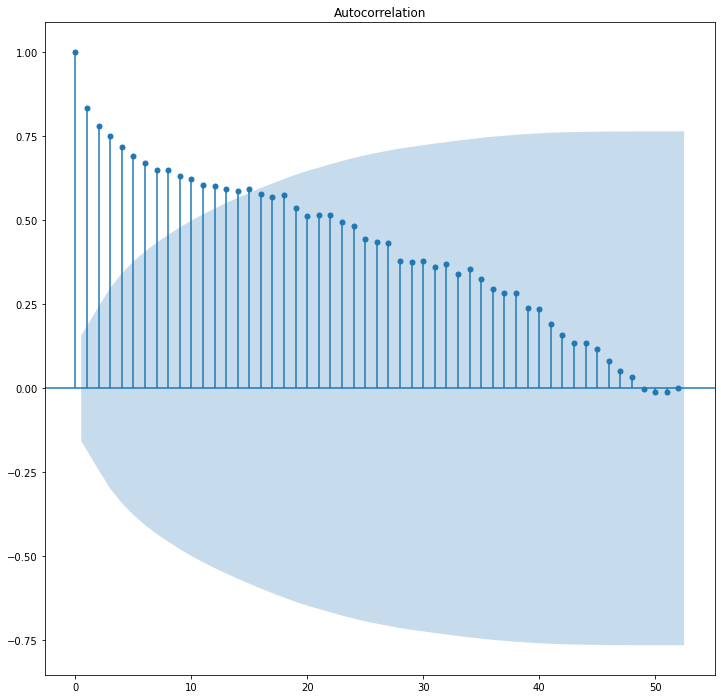

In [189]:
plot_acf(semanal.cantidad_pasos, lags = 52)
plt.show()

En la medida que se avanza en los datos de la serie de tiempo, se va perdiendo la confianza predictoria que estos puedan llegar a tener. 
Se puede apreciar en el gráfico que es hasta los primeros 3 meses de datos que quedan por fuera del intervalo de confianza. Llegando así a la conclusión que serán 3 meses los que se utilizarán como look-back para los modelos predictorios. 

# 4. Modelos Machine Learning

### Definiendo Test y Train

In [191]:
senial = semanal.cantidad_pasos
look_back = 16 #Utilizo 16 semanas para predecir 1

In [193]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1) 
print(X.shape, y.shape)

(139, 16) (139,)


In [194]:
N

156

In [195]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back] 
    y[i] = senial.iloc[i+look_back] 

In [196]:
print(X)

[[347212. 366413. 357215. ... 342359. 304912. 342225.]
 [366413. 357215. 354581. ... 304912. 342225. 350946.]
 [357215. 354581. 359401. ... 342225. 350946. 325875.]
 ...
 [274513. 265594. 279775. ... 281790. 264500. 266555.]
 [265594. 279775. 276271. ... 264500. 266555. 282891.]
 [279775. 276271. 272592. ... 266555. 282891. 272960.]]


In [197]:
print(y)

[350946.  325875.  309072.  324240.  307054.  319937.  335147.  328122.
 316651.  335900.  323159.  347770.  357156.  342240.  345164.  334245.
 337243.  316987.  337659.  337933.  374520.  353999.  357671.  369918.
 377832.  342571.  366650.  353947.  375644.  377263.  359053.  371970.
 364991.  365063.  327602.  309692.  300242.  315780.  328359.  327887.
 340275.  348044.  318733.  325966.  349768.  346506.  352713.  361465.
 325545.  323725.  339255.  325904.  322154.  287470.  324115.  325304.
 310709.  307369.  314291.  296834.  288154.  292119.5 310012.  312335.
 314517.  294270.  300955.  301407.  308307.  290940.  293436.  298932.
 284913.  295210.  278806.5 247986.  312089.  296381.  304897.  307134.
 294310.  307352.  288934.  270948.5 320481.  315645.  314832.  250861.
 246994.  267123.  252617.  259019.  276568.  258204.  273664.  284439.
 288919.  285547.  278834.  276714.  298638.  267797.  266745.  265423.
 273282.  252104.  281283.  271796.  271232.  275654.5 284432.  

In [198]:
N_train = 127 # cantidad de instancias que vamos a usar para entrenar. 
N_test = 12 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print("Train", X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print("Test", X_test.shape, y_test.shape)
#12 = los últimos 3 meses que voy a predecir

Train (127, 16) (127,)
Test (12, 16) (12,)


### Métrica a utilizar para evaluar los modelos 


La métrica que se va a utilizar para evaluar los siguientes modelos será el Root Squared Mean Error para medir la distancia de los errores predichos contra los valores reales. Donde entre más distancia entre lo predicho y lo real, mayor será el error del modelo. 

### A) Modelo Benchmark

In [199]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

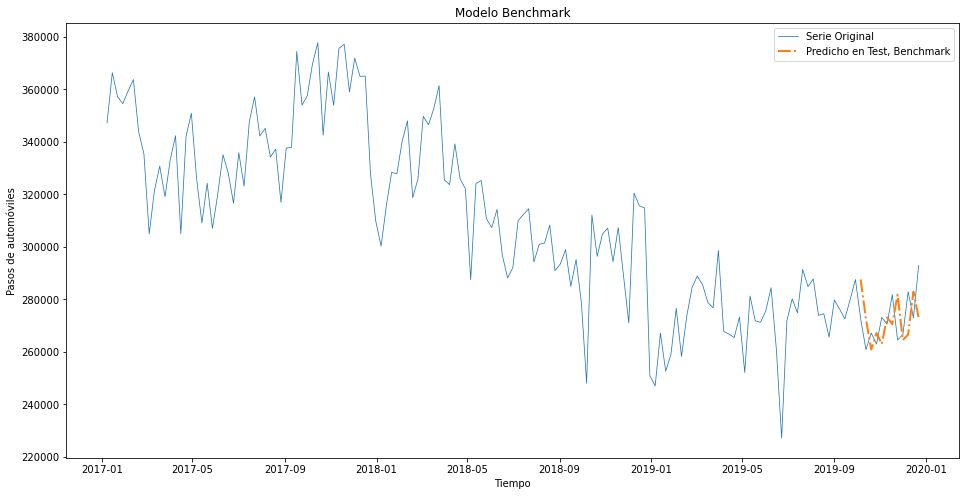

In [200]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlabel('Tiempo')
plt.ylabel('Pasos de automóviles')
plt.title('Modelo Benchmark')
plt.legend()
plt.show()

In [201]:
MSE = mean_squared_error(y_test, y_test_pred_benchmark)
print("El error en Test RMSE es ", np.sqrt(MSE))

El error en Test RMSE es  11982.629653655606


#### Conclusiones Modelo Benchmark

Al ser un modelo que utiliza como valores predichos los valores reales de la semana pasada, la gráfica parece que va un poco retrasada. 


Es un buen punto de partida, ya que ahora sabemos que debemos buscar errores menores con un modelo de machine learning que  simplemente colocar los valores de la semana pasada. 

### B) Modelo Random Forest; One Step Prediction

In [202]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

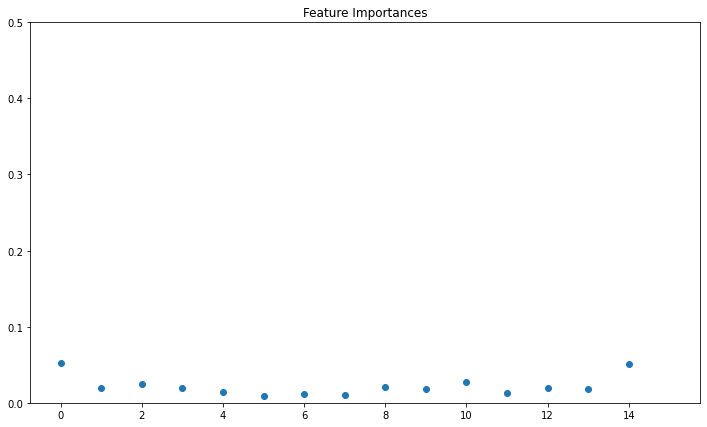

In [203]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
plt.title("Feature Importances")
plt.ylim([0,.5])
plt.show()

In [204]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

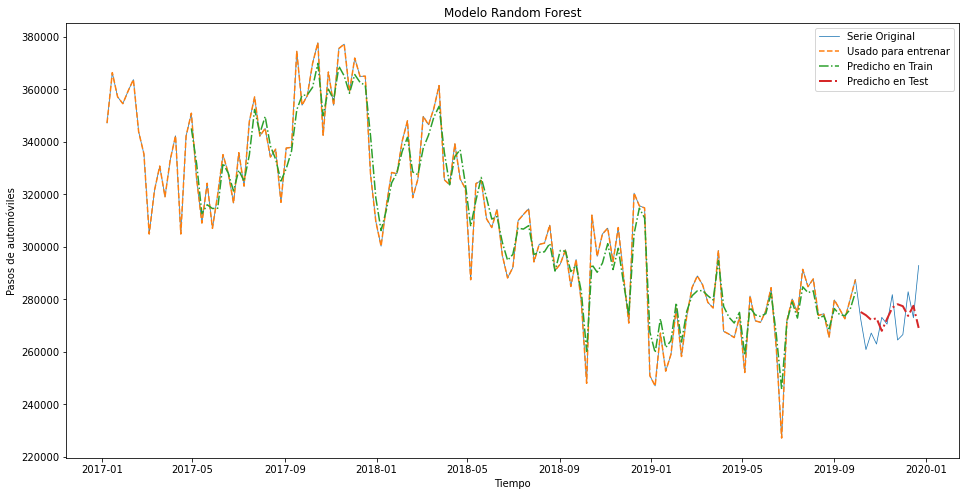

In [205]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.title('Modelo Random Forest')
plt.xlabel('Tiempo')
plt.ylabel('Pasos de automóviles')
plt.show()

In [206]:
MSE_train = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE_train))

MSE_test = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE_test))

Error en Train: 6906.989268695644
Error en Test: 10530.54340730404


#### Conclusiones

Podemos concluir que el modelo de Random Forest muestra una mejora del 17% respecto al modelo benchmark. Se obtiene dicha mejora sin haber realizado una optimización de hiperparámetros aún. Además, el modelo presenta poca varianza entre los resultados del train y del test. 


### C) Modelo Decision Tree Regressor

In [207]:
arbol = DecisionTreeRegressor(max_depth = 10).fit(X_train,y_train)

In [208]:
y_pred = arbol.predict(X)
y_train_pred = arbol.predict(X_train)
y_test_pred = arbol.predict(X_test)

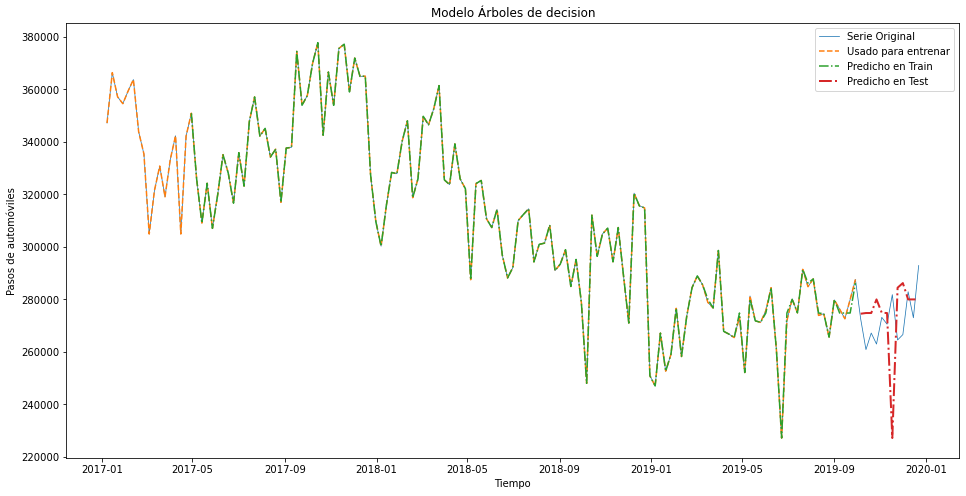

In [209]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos de automóviles')
plt.title('Modelo Árboles de decision')
plt.show()

In [210]:
MSE_train = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE_train))

MSE_test = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE_test))

Error en Train: 644.0811860633098
Error en Test: 19500.37862818135


#### Conclusiones

El modelo de árbol de regresión es el que ha mostrado un desempeño más bajo. Muestra una gran varianza entre los resultados de train y los resultados de test. Además, se puede apreciar un gran overfitting por parte del modelo al presentar errores muy bajos en train, y los errores más altos de los modelos analizados en test. 

### D) Modelo XGBoost

In [211]:
bst = xgb.XGBRegressor(objective = 'reg:squarederror')

In [212]:
bst = xgb.XGBRegressor()

In [213]:
#bst = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                #max_depth = 5, alpha = 10, n_estimators = 10)

In [214]:
bst.fit(X_train, y_train, eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:180873.50000
[1]	validation_0-rmse:123742.98438
[2]	validation_0-rmse:85409.78906
[3]	validation_0-rmse:60222.59375
[4]	validation_0-rmse:42813.65625
[5]	validation_0-rmse:31702.76172
[6]	validation_0-rmse:23369.51367
[7]	validation_0-rmse:18245.73438
[8]	validation_0-rmse:14955.70996
[9]	validation_0-rmse:13141.11621
[10]	validation_0-rmse:12105.90625
[11]	validation_0-rmse:11726.46289
[12]	validation_0-rmse:11434.78320
[13]	validation_0-rmse:11476.89844
[14]	validation_0-rmse:11438.62012
[15]	validation_0-rmse:11427.85840
[16]	validation_0-rmse:11456.67090
[17]	validation_0-rmse:11455.91894
[18]	validation_0-rmse:11608.08594
[19]	validation_0-rmse:11661.12695
[20]	validation_0-rmse:11747.06543
[21]	validation_0-rmse:11792.32617
[22]	validation_0-rmse:11724.79590
[23]	validation_0-rmse:11726.61426
[24]	validation_0-rmse:11694.78223
[25]	validation_0-rmse:11780.06348
[26]	validation_0-rmse:11763.67481
[27]	validation_0-rmse:11764.95117
[28]	validation_0-rmse:11768

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

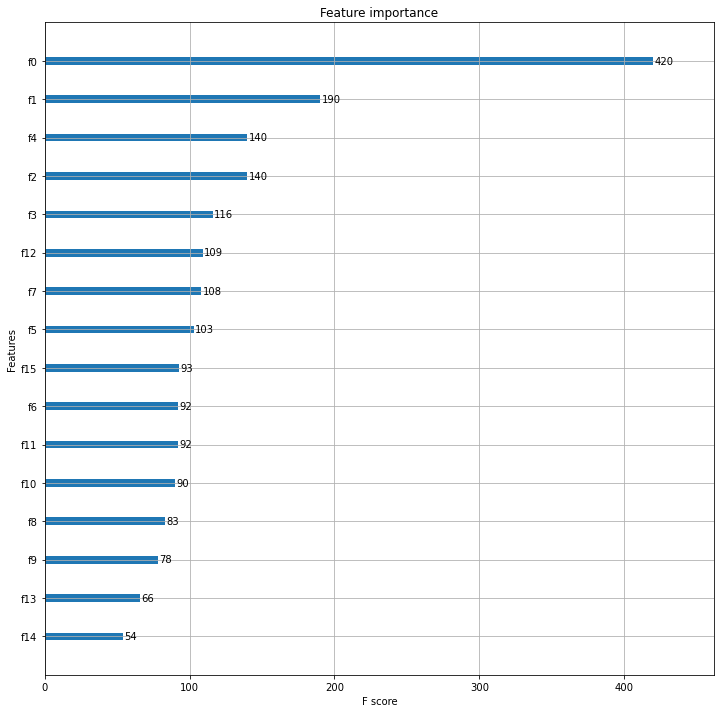

In [215]:
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [216]:
y_pred = bst.predict(X)
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)

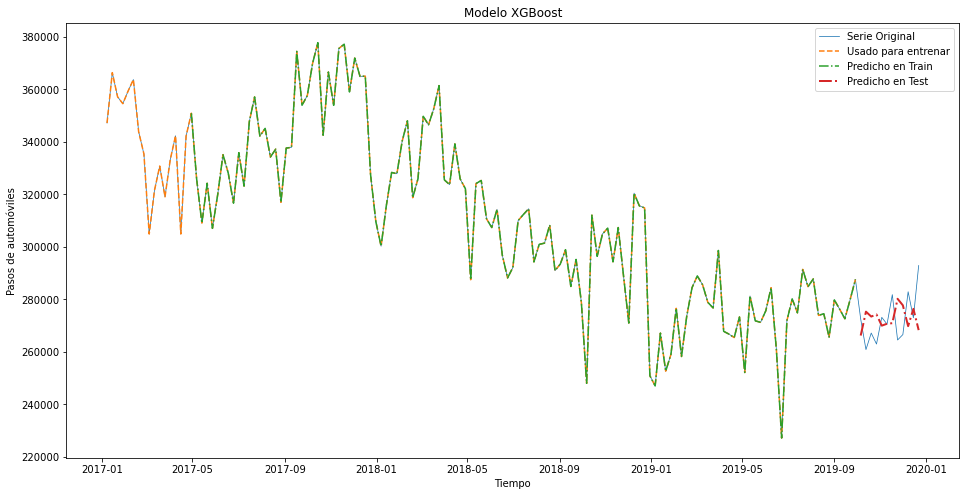

In [217]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos de automóviles')
plt.title('Modelo XGBoost')
plt.show()

In [218]:
MSE_train = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE_train))

MSE_test = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE_test))

Error en Train: 0.44500427497835987
Error en Test: 11918.277522268854


#### Conclusiones

El modelo implementado con XGBoost presenta muy bajo error cuando se realiza el Train. Sin embargo, presenta un error elevado cuando se realiza el Test, mostrando una gran varianza en los resultados. Dicho lo anterior, se puede apreciar un gran over-fitting por parte del modelo. Esto se puede apreciar en la gráfica de errores realizada, donde en la parte predicha en el Test, el modelo trata de asimilar un poco la el tramo de las semanas 130-140. 

De igual manera, el error obtenido en Test es el más alto que se ha obtenido dentro de estos 4 modelos diferentes. 



### Conclusiones generales de los modelos

Luego de haber utilizado 4 modelos diferentes, se opta por elegir el modelo de Random Forest; One Step Prediction. Esto debido a que es el modelo que presentó el menor error en test, y que además, presenta muy poca varianza entre los resultados de train y test. 

# 5. Optimización de Hiperparámetros

A continuación se procede a realizar la optimización de los hiperparámetros para el modelo de Random Forest. 

### Calculando valores óptimos

In [219]:
rf = RandomForestRegressor()#.fit(X_train,y_train)

In [220]:
param_grid = {'n_estimators':[100,150,200,250], 
             'max_depth':[5,10,15,20,25,30,40,50]}

In [221]:
model = GridSearchCV(rf, param_grid=param_grid, cv=5,scoring = 'neg_root_mean_squared_error')

In [222]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 40, 50],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_root_mean_squared_error')

In [223]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'max_depth': 10, 'n_estimators': 200}
Mejor Score: -16865.664901745862



### Utilizando hiperparámetros en el modelo

In [224]:
rf = RandomForestRegressor(max_depth = 15, n_estimators = 250).fit(X_train,y_train)

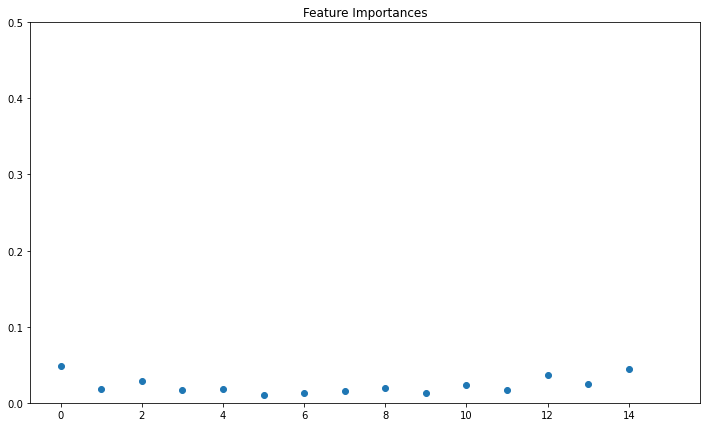

In [225]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
plt.title("Feature Importances")
plt.ylim([0,.5])
plt.show()

El modelo le da el mayor peso en primer lugar al valor de la última semana y en segundo lugar al valor de la tercer semana que tiene disponible para trabajar. 

In [226]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

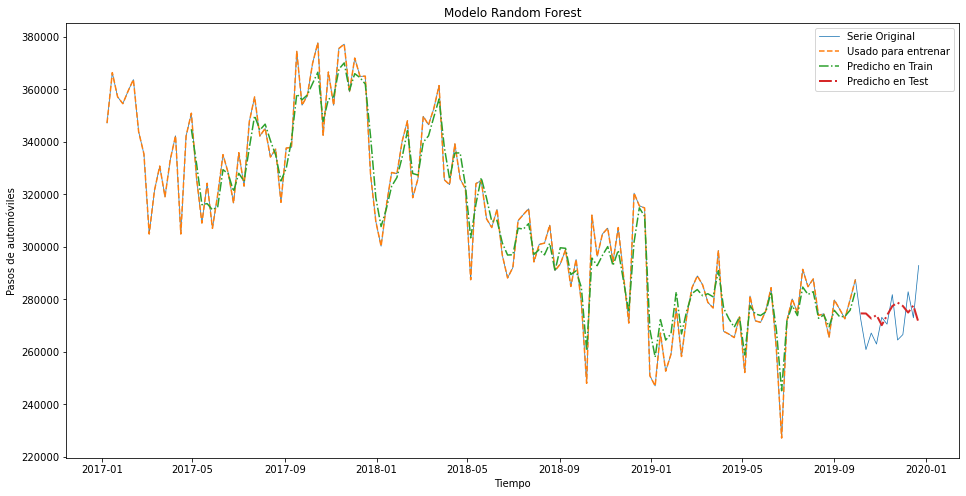

In [227]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 2, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Pasos de automóviles')
plt.title('Modelo Random Forest')
plt.show()

Para los valores predichos en Test, se puede apreciar como el modelo medianamente replica la forma de los valores de Train en las semanas 130 a 140. 

In [228]:
MSE_train = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE_train))

MSE_test = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE_test))

Error en Train: 6790.402191133966
Error en Test: 10300.145907560496


# 6. Comparando predicciones vs Valores Reales

A continuacion se realizan las predicciones para las primeras 12 semanas del año 2020. 

In [229]:
new_x = X_test[11,:]
list_predict = []

for i in range(12):
    prediccion = rf.predict(new_x.reshape(1,-1))
    new_x = np.hstack((new_x,prediccion))
    new_x = new_x[1:]
    list_predict.append(prediccion[0])
    
print(list_predict)
    #X[i,:] = senial.iloc[i:i+look_back] 
    #y[i] = senial.iloc[i+look_back] 

[270958.262, 274291.552, 275951.73, 275020.312, 275079.426, 277770.956, 275997.91, 276636.652, 275948.804, 276609.676, 274919.446, 276712.316]


In [230]:
predict = pd.DataFrame(list_predict, columns = ['predicciones'])

### Importando los valores del 2020

In [244]:
data2020 = pd.read_csv('/Users/juanmiguel/Documents/Acamica/Sprint3/Dataset Proyecto/flujo-vehicular-2020.csv', sep =',')

In [245]:
data2020.head()

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0


##### Analizando formas de pago en Illia en el año 2020

In [233]:
formadepago = data2020

In [234]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
formadepago['fecha2'] = pd.to_datetime(formadepago.fecha)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
formadepago.drop(columns=['fecha'], inplace = True)

formadepago.head()

,periodo,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha2
0,2020.0,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0,2020-01-01
1,2020.0,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0,2020-01-01
2,2020.0,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0,2020-01-01
3,2020.0,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0,2020-01-01
4,2020.0,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0,2020-01-01


In [235]:
mask2 = data2020.estacion=='ILLIA'
formadepago = data2020[mask2]

In [236]:
formadepago.head()

,periodo,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha2
52,2020.0,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Centro,326.0,2020-01-01
53,2020.0,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319.0,2020-01-01
54,2020.0,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Exento,Exento - Reglamento,Centro,2.0,2020-01-01
55,2020.0,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Exento,Exento - Reglamento,Provincia,1.0,2020-01-01
56,2020.0,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Rec.Deuda,Paso en Infracción,Centro,4.0,2020-01-01


Text(0.5, 1.0, 'Forma de Pago más utilizado en Illia en 2020')

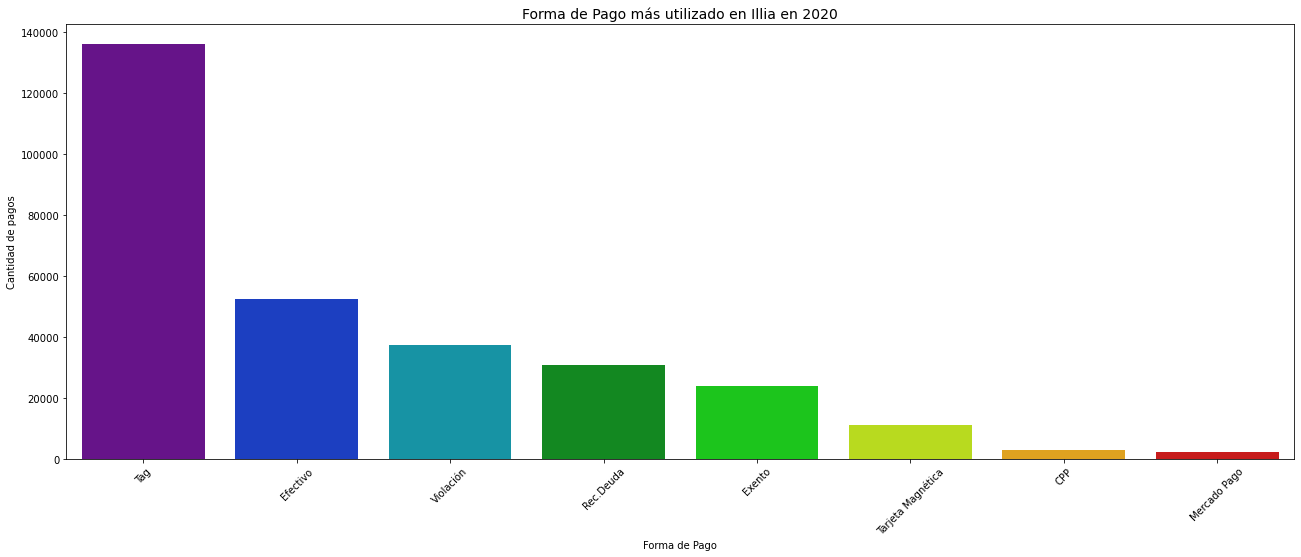

In [237]:
plt.figure(figsize=(22,8))
sns.countplot(data = formadepago, x = "forma_pago", order = formadepago['forma_pago'].value_counts().index, palette='nipy_spectral')
plt.xticks(rotation=45)
plt.xlabel('Forma de Pago')
plt.ylabel('Cantidad de pagos')
plt.title('Forma de Pago más utilizado en Illia en 2020', fontsize=14)

Podemos apreciar en el gráfico que la forma de pago más utilizada en el año 2020 en Illia fue Tag.

In [246]:
mask = np.logical_and(data2020.estacion=='ILLIA', data2020.forma_pago == 'Efectivo')
data2020 = data2020[mask]

In [247]:
data2020.head()

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
52,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Centro,326.0
53,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319.0
134,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,1.0,2.0,ILLIA,Auto,Efectivo,Efectivo,Centro,199.0
135,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,1.0,2.0,ILLIA,Auto,Efectivo,Efectivo,Provincia,180.0
202,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,2.0,3.0,ILLIA,Auto,Efectivo,Efectivo,Centro,114.0


In [248]:
data2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data2020['fecha2'] = pd.to_datetime(data2020.fecha) + pd.to_timedelta(data2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data2020.drop(columns=['fecha','hora_fin'], inplace = True)
data2020.drop(columns = ['mes','dia','dia_fecha', 'tipo_vehiculo','observacion','sentido'], inplace = True)

In [249]:
data2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

In [250]:
#Reordenamos el dataset por fecha
data2020.sort_values('fecha', inplace = True)
data2020.reset_index(drop=True, inplace = True)
data2020.head()

,cantidad_pasos,fecha
0,7.0,2020-01-01
1,423.0,2020-01-01
2,467.0,2020-01-01
3,6.0,2020-01-01
4,1.0,2020-01-01


In [251]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal2020 = data2020.resample('W', on = 'fecha').sum()
print(semanal2020.shape)

(53, 1)


In [252]:
#Nos quedamos con las primeras 12 semanas
semanal2020.reset_index(drop=True, inplace = True)
semanal2020 = semanal2020.drop(labels=range(12, 53), axis=0)

In [253]:
final = pd.concat([predict, semanal2020], axis=1)

### Comparando valores predichos vs reales

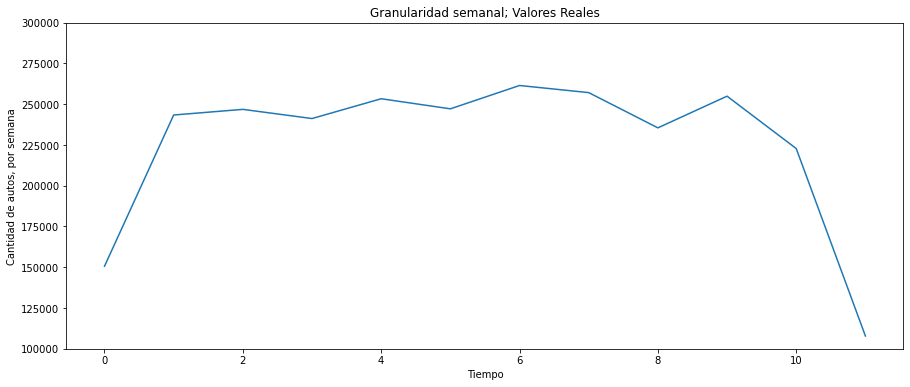

In [254]:
#Graficamos nuestros valores reales
plt.figure(figsize = (15,6))
plt.plot(semanal2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Granularidad semanal; Valores Reales')
plt.ylim([100000,300000])
plt.show()

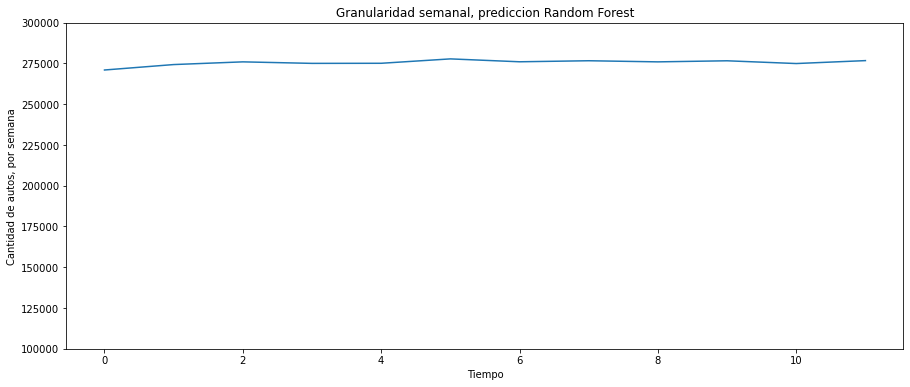

In [255]:
#Graficamos nuestros valores predichos
plt.figure(figsize = (15,6))
plt.plot(predict.predicciones)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Granularidad semanal, prediccion Random Forest')
plt.ylim([100000,300000])
plt.show()

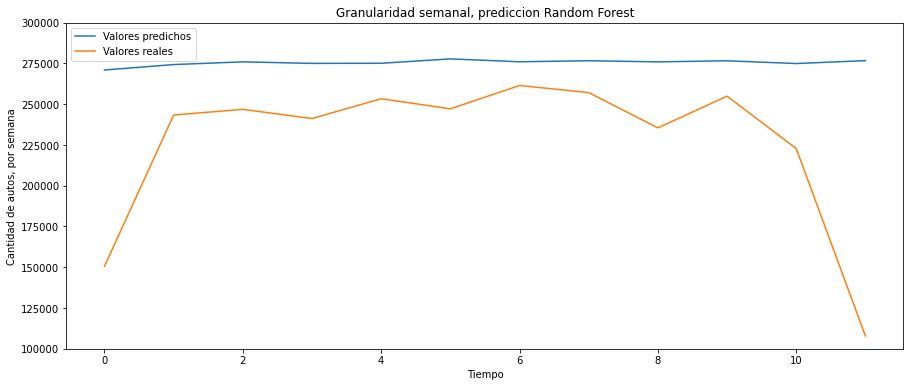

In [256]:
#Graficamos nuestros datos reales y predichos
plt.figure(figsize = (15,6))
plt.plot(predict.predicciones, label = 'Valores predichos')
plt.plot(semanal2020.cantidad_pasos,label = 'Valores reales')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Granularidad semanal, prediccion Random Forest')
plt.ylim([100000,300000])
plt.show()

## 7. Conclusiones

Dada la experiencia que tuvimos con el data set, las predicciones realizadas a futuro son bastante planas. 


Se debe tomar en cuenta la drástica caída en los pases de automóviles en la estación Illia de manera semanal a principios del 2020 que pagaron con efectivo. Los valores reales se encuentran en un rango entre 100,000 y 250,000 pases de automóviles por semana, cuando en el dataset de los años 2017, 2018 y 2019 fueron solamente 4 semanas (menos del 5%) las que presentaron valores por debajo de los 250,000. 

Si bien el tráfico se puede ver disminuido en todo el año 2020 debido a la pandemia generada por el Covid-19, no fue hasta el 11 de marzo que la OMS lo declaró como pandemia y posterior a ello fue que los diversos gobiernos (incluido el de Argentina) comenzaron a tomar medidas de cuarentena. Por lo que no es una razón válida para explicar la disminución del tráfico en la estación. De hecho, comparando las transacciones con el método de pago en efectivo entre los años 2019 y 2020, podemos ver que hubo alrededor de 10,000 pasos más en el año 2020 que fueron pagados con efectivo.  

El modelo realizado no lográ predecir en ninguna de las primeras 12 semanas el valor real de los pasos de automóviles. 

Para el modelo utilizando los valores de Test, sí tenía esperado que el modelo tratará de replicar las últimas semanas de las que tiene registro, aunque no fue muy buen método de predicción, ya que hay factores como la estacionalidad que muy probablemente no estén siendo tomados en cuenta. 

Para comenzar, me gustaría implementar un modelo sin la filtración de métodos de pago, ya que el método de pago de efectivo presento una tendencia de disminución en los años estudiados, pero eso no implica que el tráfico en total haya disminuido, pues en el año 2018 aumentaron los pases pagados con Telepase/Tag. Considero conveniente analizar todos los pases sin distinción alguna de que forma de pago se utilizó para determinar si verdaderamente hay una tendencia a la baja en la estación Illia.  

De igual manera, me gustaría lograr la implementación de modelos de predicción más complejos como Prophet o Arima. Si bien los modelos utilizados en este notebook son buenos, se han desarrollado modelos con mejor poder predictivo para las series de tiempo que muy probablemente lograrían una mejor predicción tanto para el último trimestre del 2019 como para el primero del 2020. 

Al aplicar las investigaciones propuestas, en primer lugar espero tener un conjunto de datos que no presente una tendencia a la baja. Espero que sea una tendencia que se vaya incrementando ligeramente año con año. Con el dataset propuesto, esperaría que los modelos sean capaces de darle un mejor sentido a las estacionalidades y por ende, presentar mejores predicciones. 

Una vez que se maneje el dataset con todos los métodos de pago en la estación Illía y la implementación de modelos como Arima o Prophet, esperaría tener modelos más finos y que logren realizar mejores predicciones con menores errores para el test. 

In [266]:
semanal.to_csv('/Users/juanmiguel/Documents/Acamica/Proyecto_4/Datasetsemanal.csv',index= True)